### One step forecast using the LSTM model    

I order to po

In [9]:
from utils import *
from lstm import *

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

n_forecast_days = 1
n_lag_days = 30
n_features = 6

n_test_days = 360

n_neurons = 20
n_epochs = 300
batch_size = 60

In [10]:
df_t = read_target_df('vod-pro/Farkasic H.csv')

df_2 = read_target_df('vod-pro/Jamnicka kiselica H.csv')
df_3 = read_target_df('vod-pro/Karlovac H.csv')
df_4 = read_target_df('vod-pro/Kamanje H.csv')

df_5 = read_csv('padaline-full/plaski.csv')
df_6 = read_csv('padaline-full/pisarovina.csv')

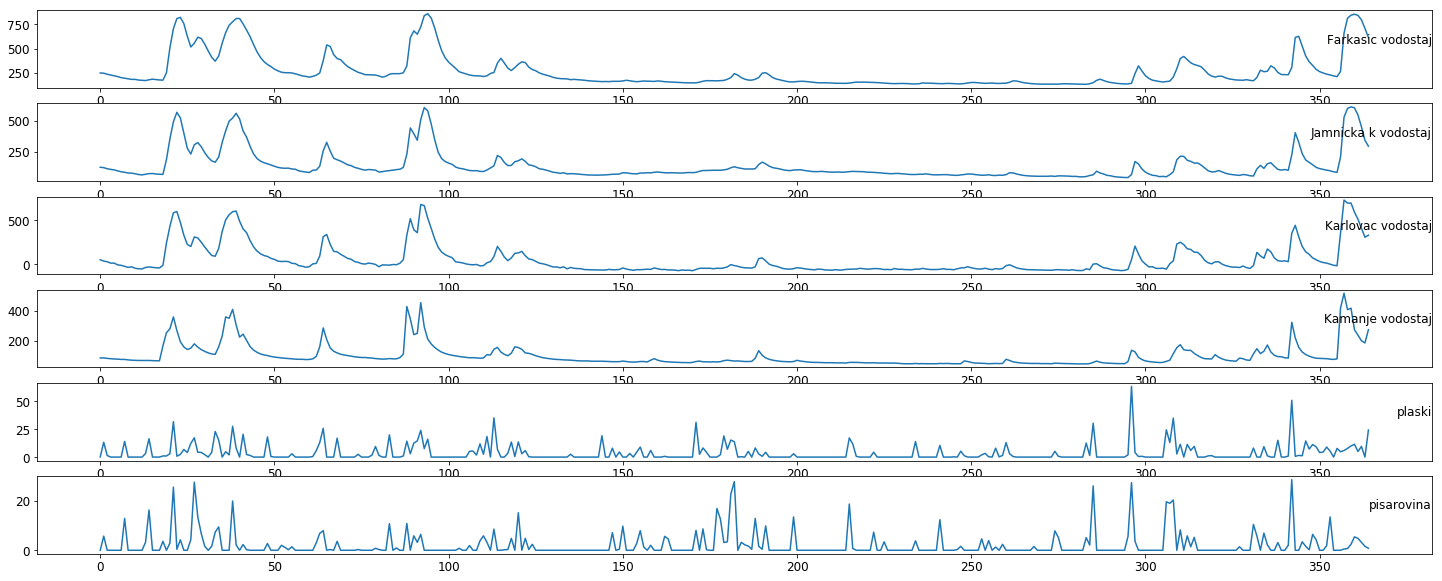

In [11]:
dataset = DataFrame()
dataset["Farkasic vodostaj"] = df_t.target
dataset["Jamnicka k vodostaj"] = df_2.target
dataset["Karlovac vodostaj"] = df_3.target
dataset["Kamanje vodostaj"] = df_4.target

dataset["plaski"] = df_5.padaline
dataset["pisarovina"] = df_6.padaline


plot_multi_dataframe(dataset, 0, 365)

In [12]:
supervised = series_to_supervised(dataset[1:], n_lag_days, n_forecast_days)
print_df_info(supervised)

(2160, 181)
var1(t-30)    float64
var2(t-30)    float64
var3(t-30)    float64
var4(t-30)    float64
var5(t-30)    float64
var6(t-30)    float64
var1(t-29)    float64
var2(t-29)    float64
var3(t-29)    float64
var4(t-29)    float64
var5(t-29)    float64
var6(t-29)    float64
var1(t-28)    float64
var2(t-28)    float64
var3(t-28)    float64
var4(t-28)    float64
var5(t-28)    float64
var6(t-28)    float64
var1(t-27)    float64
var2(t-27)    float64
var3(t-27)    float64
var4(t-27)    float64
var5(t-27)    float64
var6(t-27)    float64
var1(t-26)    float64
var2(t-26)    float64
var3(t-26)    float64
var4(t-26)    float64
var5(t-26)    float64
var6(t-26)    float64
               ...   
var2(t-5)     float64
var3(t-5)     float64
var4(t-5)     float64
var5(t-5)     float64
var6(t-5)     float64
var1(t-4)     float64
var2(t-4)     float64
var3(t-4)     float64
var4(t-4)     float64
var5(t-4)     float64
var6(t-4)     float64
var1(t-3)     float64
var2(t-3)     float64
var3(t-3)     float6

In [13]:
values = supervised.values
train = values[:-n_test_days, :]
test = values[-n_test_days:, :]
print(train.shape, test.shape)

scaler, train_scaled, test_scaled = scale(train, test, 0, 1)
print(train_scaled.shape, test_scaled.shape)

(1800, 181) (360, 181)
(1800, 181) (360, 181)


In [14]:
X_train, y_train = train_scaled[:, 0:-n_forecast_days], train_scaled[:, -n_forecast_days:]
X_train_reshaped = X_train.reshape(X_train.shape[0], n_lag_days, n_features)
    
X_test, y_test = test_scaled[:, 0:-n_forecast_days], test_scaled[:, -n_forecast_days:]
X_test_reshaped = X_test.reshape(X_test.shape[0], n_lag_days, n_features)    

In [15]:
def run_forecast():
    #Fitting
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(batch_size, n_lag_days, n_features), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(n_epochs):
        history = model.fit(X_train_reshaped, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)

    from sklearn.metrics import mean_absolute_error

    #walk forward validation
    test_model = Sequential()
    test_model.add(LSTM(n_neurons, batch_input_shape=(1, n_lag_days, n_features), stateful=True))
    test_model.add(Dense(1))
    test_model.compile(loss='mean_squared_error', optimizer='adam')
    test_model.set_weights(model.get_weights())
    
    yhat_train = test_model.predict(X_train_reshaped, batch_size=1)
    inv_yhat_train = scaler.inverse_transform(np.hstack([X_train, yhat_train]))[:, -1]

    yhat_test = test_model.predict(X_test_reshaped, batch_size=1)
    inv_yhat_test = scaler.inverse_transform(np.hstack([X_test, yhat_test]))[:, -1]
    
    exhaustive_report(train[:, -1], inv_yhat_train, test[:, -1], inv_yhat_test)

TRAIN
rmse:  15.522230082823285
mae:  9.00404724922
TEST
rmse:  28.601118001087034
mae:  18.6354907586


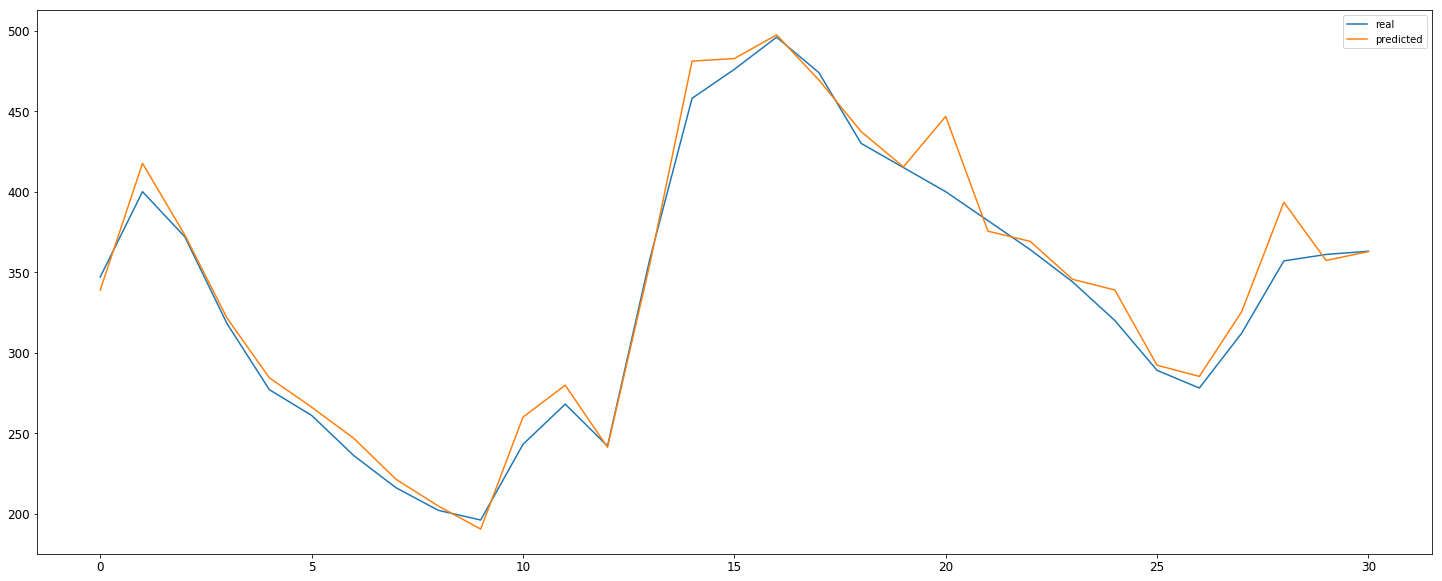

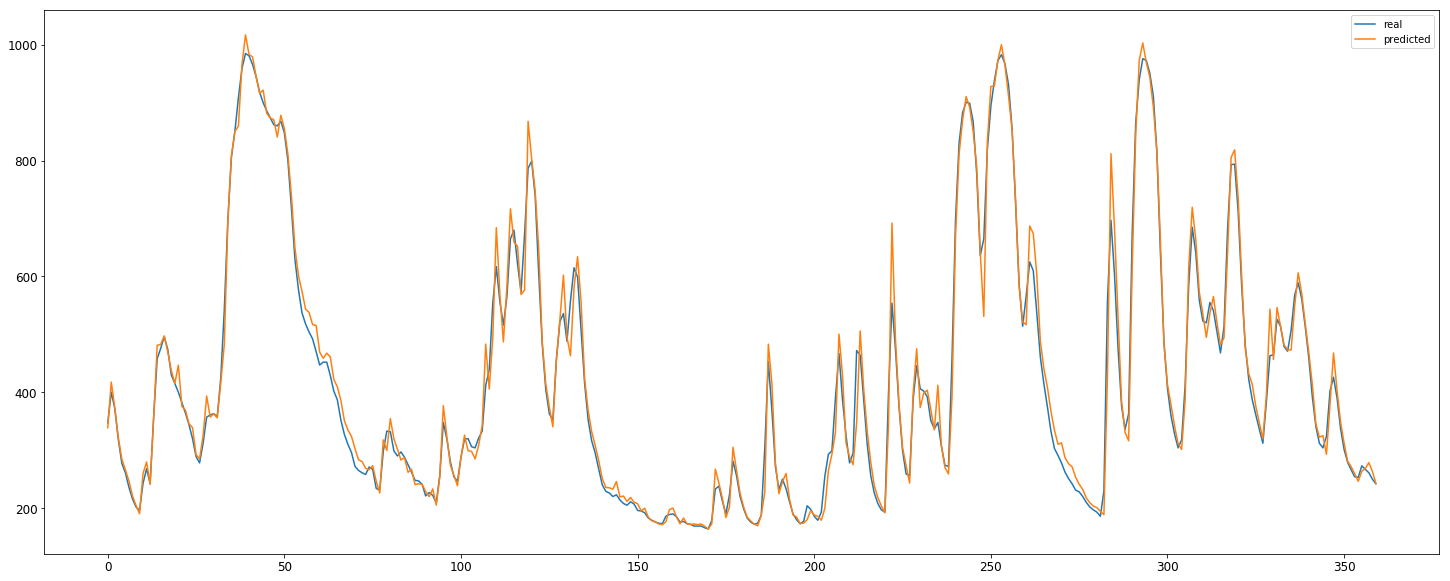

KeyboardInterrupt: 

In [16]:
for i in range(3):
    run_forecast()